- Multiple Linear Regression using Sci-Kit learn
- Building baseline model
- Polynomial Regression
- Implementing Lasso Regularization
- Building pipeline
- Using cross validation score to get the best alpha

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn import metrics
import seaborn as sns
from sklearn.feature_selection import f_regression
import warnings
warnings.filterwarnings('ignore')
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from scipy import stats
from sklearn.pipeline import Pipeline

In [2]:
## Import Dataset ###
df = pd.read_csv(r'.\Datasets\Combined_Cycle_Power_Plant.csv')
print(df.shape)
df.head(3)

(47840, 5)


AT      V       AP     RH      EP
0  14.96  41.76  1024.07  73.17  463.26
1  25.18  62.96  1020.04  59.08  444.37
2   5.11  39.40  1012.16  92.14  488.56

In [3]:
## Investigate the dataframe for any null values ###
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47840 entries, 0 to 47839
Data columns (total 5 columns):
AT    47840 non-null float64
V     47840 non-null float64
AP    47840 non-null float64
RH    47840 non-null float64
EP    47840 non-null float64
dtypes: float64(5)
memory usage: 1.8 MB


In [4]:
df.describe()

AT             V            AP            RH            EP
count  47840.000000  47840.000000  47840.000000  47840.000000  47840.000000
mean      19.651440     54.305804   1013.259078     73.308978    454.365009
std        7.452015     12.707362      5.938535     14.599658     17.066281
min        1.810000     25.360000    992.890000     25.560000    420.260000
25%       13.510000     41.740000   1009.100000     63.327500    439.750000
50%       20.345000     52.080000   1012.940000     74.975000    451.550000
75%       25.720000     66.540000   1017.260000     84.830000    468.430000
max       37.110000     81.560000   1033.300000    100.160000    495.760000

Let's see the distribution of the EP using a histogram plot and see if there are any outliers in the data using boxplot.

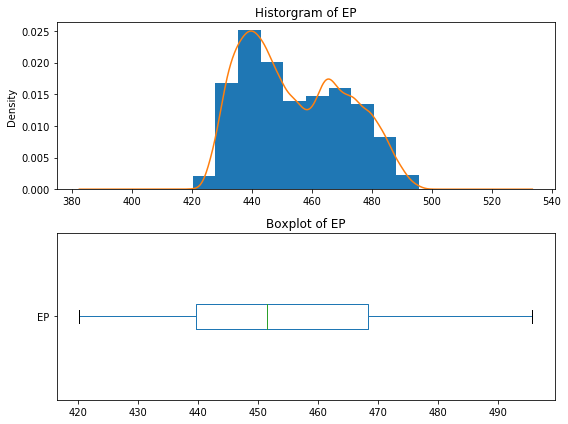

In [7]:
## Plot for price ##
plt.figure(figsize = (8, 6))
plt.subplot(2, 1, 1)
df.EP.plot.hist(bins = 10, normed = True)
df.EP.plot.kde(title = "Historgram of EP")

plt.subplot(2, 1, 2)
df.EP.plot.box(vert = False, title = "Boxplot of EP")

plt.tight_layout()

As we can see the distribution for EP is bimodal.

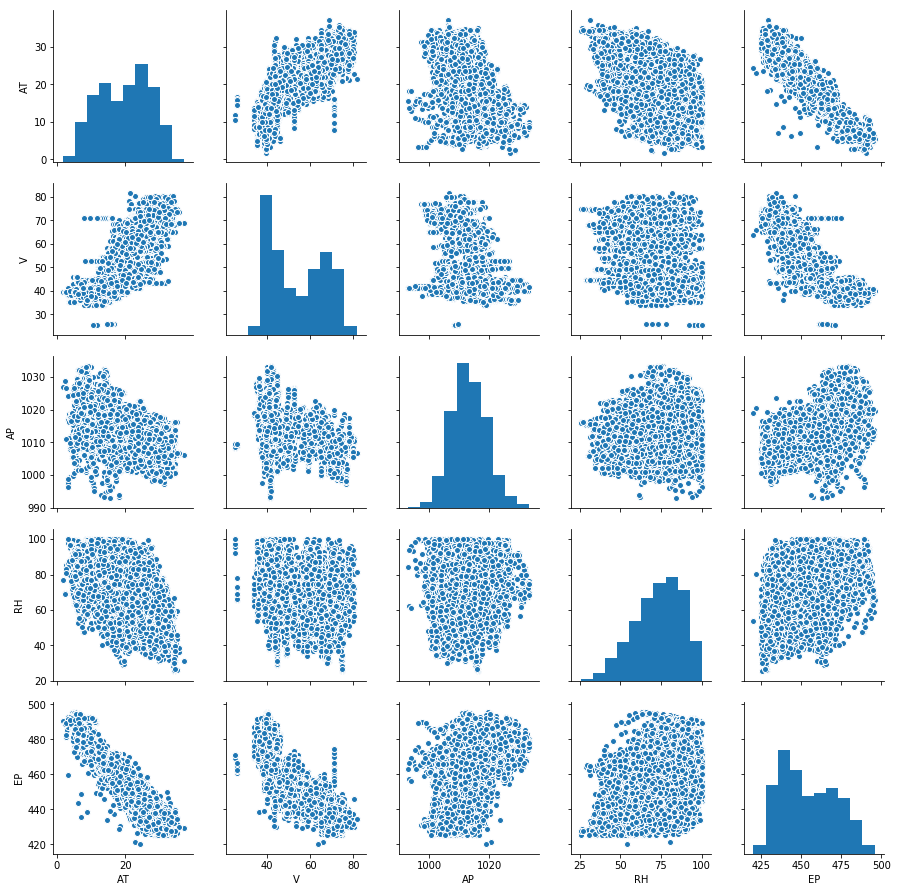

In [8]:
sns.pairplot(df)

In [9]:
### Correlation matrix
df.corr()

AT         V        AP        RH        EP
AT  1.000000  0.844092 -0.507548 -0.542530 -0.948119
V   0.844092  1.000000 -0.413502 -0.312187 -0.869780
AP -0.507548 -0.413502  1.000000  0.099574  0.518429
RH -0.542530 -0.312187  0.099574  1.000000  0.389794
EP -0.948119 -0.869780  0.518429  0.389794  1.000000

In [10]:
y = df['EP'].values
X = df[df.columns[~df.columns.isin(['EP'])]].values
X_cols = df.columns[~df.columns.isin(['EP'])]
X_org = df[df.columns[~df.columns.isin(['EP'])]]

In [11]:
## Normalize the features using Z-score ###
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
## Train Test Split ###
X_train,X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state =100)
print("Train Size: ", X_train.shape, y_train.shape)
print("Test Size: ", X_test.shape, y_test.shape)

Train Size:  (38272, 4) (38272,)
Test Size:  (9568, 4) (9568,)


### Fitting Baseline/default Multiple Regression Model

In [14]:
### Fitting Linear Regression Default Model ###
model_default = LinearRegression()
model_default.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [15]:
## Model intercept & coefficients ##
model_default.intercept_, model_default.coef_

(454.35574577132945,
 array([-14.74557573,  -2.98637925,   0.35415204,  -2.30952837]))

In [16]:
## Predicting Test Set ###
y_test_pred = model_default.predict(X_test)

n = X_test.shape[0]; p= X_test.shape[1]
r2_score = metrics.regression.r2_score(y_test, y_test_pred)
Adj_r2_score = 1-(1-r2_score)*(n-1)/(n-p-1)

## Measuring Model Performance ##
print("###  Test Performance ###")
print("r2_score: ",r2_score)
print("Adj_r2_score: ",Adj_r2_score)
print("mean_squared_error: ",metrics.regression.mean_squared_error(y_test, y_test_pred))
print("root_mean_squared_error: ",np.sqrt(metrics.regression.mean_squared_error(y_test, y_test_pred)))

###  Test Performance ###
r2_score:  0.9287212104183139
Adj_r2_score:  0.9286913960129676
mean_squared_error:  20.668455354029998
root_mean_squared_error:  4.546257290786565


In [17]:
## Predicting Training Set ###
y_train_pred = model_default.predict(X_train)

n = X_train.shape[0]; p= X_train.shape[1]
r2_score = metrics.regression.r2_score(y_train, y_train_pred)
Adj_r2_score = 1-(1-r2_score)*(n-1)/(n-p-1)

## Measuring Model Performance ##
print("###  Train Performance  ###")
print("r2_score: ",r2_score)
print("Adj_r2_score: ",Adj_r2_score)
print("mean_squared_error: ",metrics.regression.mean_squared_error(y_train, y_train_pred))
print("root_mean_squared_error: ",np.sqrt(metrics.regression.mean_squared_error(y_train, y_train_pred)))

###  Train Performance  ###
r2_score:  0.9286693461995378
Adj_r2_score:  0.9286618900985839
mean_squared_error:  20.797247361506667
root_mean_squared_error:  4.560399912453585


Baseline model or default model is giving good result.
Train R2 score = 92.8% whereas Test R2 score = 92.8%
Train Adj R2 score = 92.8% whereas Test Adj R2 score = 92.8%


In [18]:
## Inverse transform to bring values to original scale ##
X_test_inv = scaler.inverse_transform(X_test)

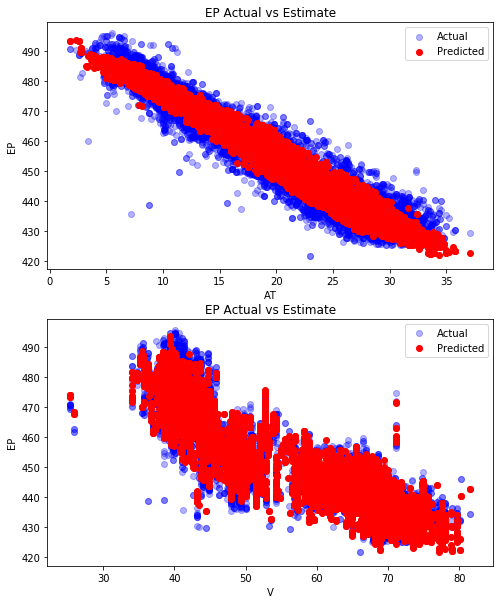

In [19]:
## Plot for enginesize ##
plt.figure(figsize = (8, 10))
plt.subplot(2, 1, 1)

plt.scatter(X_test_inv[:, 0], y_test, alpha = 0.3, c = "blue", label = "Actual")
plt.scatter(X_test_inv[:, 0], y_test_pred, c = "red", label = "Predicted")

plt.xlabel("AT")
plt.ylabel("EP")
plt.title("EP Actual vs Estimate")
plt.legend()


plt.subplot(2, 1, 2)
## Plot for horsepower ##
plt.scatter(X_test_inv[:, 1], y_test, alpha = 0.3, c = "blue", label = "Actual")
plt.scatter(X_test_inv[:, 1], y_test_pred, c = "red", label = "Predicted")

plt.xlabel("V")
plt.ylabel("EP")
plt.title("EP Actual vs Estimate")
plt.legend()

### Significance Scores for feature selection

p-value indicates the significant scores for each feature. p-value < 0.05 indicates, the corresponding feature is statistically significant. We can rebuild the model excluding the non-significant features one by one until all remaining features are significant. 


We can also evaluate feature significance using correlation.

+1             => Perfect positive correlation

-1             => Perfect negative correlation

0              => No Correlation

0 to 0.25      => Weak positive correlation

0.25 to 0.75   => Moderate positive correlation

0.75 to 1      => Strong positive correlation

-0.25 to 0     => Weak negative correlation

-0.25 to -0.75 => Moderate negative correlation

-0.75 to -1    => Strong negative correlation

In [20]:
_, p_vals = f_regression(X_train, y_train)
selected_features = pd.DataFrame({"feature": X_cols, "p_value": p_vals})
selected_features.loc[selected_features['p_value']<0.05, 'Significance_pval'] = 'Significant'
selected_features.loc[selected_features['p_value']>=0.05, 'Significance_pval'] = 'Not Significant'

In [21]:
selected_features

feature  p_value Significance_pval
0      AT      0.0       Significant
1       V      0.0       Significant
2      AP      0.0       Significant
3      RH      0.0       Significant

As we can see all the features are significant.

### Checking assumptions of Multiple Linear Regression (Model 3)

1. Linear relationship between Target variables and predictors.
2. No Multicollinearity => Predictors should not be correlated with each other. It should be checked using VIF. 

   If VIF <= 4 ---> No Multicollinearity
   If VIF >=10 ---> Serious Multicollinearity
   
   
3. No Autocorrelation => There should be no auto-correlation among error terms. It should be checked using Durbin-Watson test.

   If DW = 2 ---> No Autocorrelation
   If 0 < DW < 2 ---> Positive Autocorrelation
   If 2 < DW < 4 ---> Negative Autocorrelation
   
   
4. No Hetroskedascity => Errors must have a constant variance. It should be checked using residual vs fitted plot. 
   If it  exhibits a funnel shape pattern =>  Hetroskedascity is there
   It can also be checked using White general test
   
5. Error terms must be normally distributed. It can be checked using Shapiro-Wilk test or by checking Q-Q plot

Durbin Watson Coefficient is  1.994787215156765


((array([-3.79967944, -3.57391754, -3.44994448, ...,  3.44994448,
          3.57391754,  3.79967944]),
  array([-43.45675306, -43.45675306, -43.04546809, ...,  17.44430887,
          17.79457625,  17.79457625])),
 (4.50527414086987, 0.046317129975316104, 0.9906677742583965))

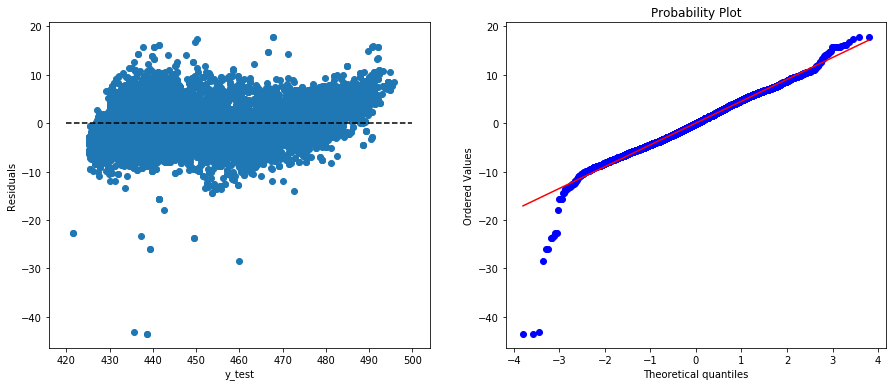

In [23]:
residuals_test = y_test - y_test_pred

#Durbin Watson test for checking autocorrelation
print("Durbin Watson Coefficient is ", durbin_watson(residuals_test))

# Checking for Hetroskedescity
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, residuals_test)
plt.xlabel("y_test")
plt.ylabel("Residuals")
plt.hlines([0], xmin = 420, xmax = 500, linestyles = "dashed")

plt.subplot(1, 2, 2)
## Q-Q plot for checking residuals are normally distributed or not
stats.probplot(residuals_test, plot=plt)

Residual plots show there are outliers in the lower end of the y_test values. qqPlot shows that residuals do not exhibit normaality, indicating non linearity in the model.

### Polynomial Regression
- Lasso Regression
- Building pipeline 

In [24]:
poly = PolynomialFeatures(degree=2)

X_poly = poly.fit_transform(X)
#X_poly = poly.fit_transform(X_org[feature_set.values].values)

## Train Test Split ###
X_poly_train,X_poly_test, y_train, y_test = train_test_split(X_poly, y, test_size = 0.20, random_state =100)
print("Train Size: ", X_poly_train.shape, y_train.shape)
print("Test Size: ", X_poly_test.shape, y_test.shape)

X_poly_train_scaled = scaler.fit_transform(X_poly_train)
X_poly_test_scaled = scaler.transform(X_poly_test)
pd.DataFrame(X_poly_train_scaled).head()

Train Size:  (38272, 15) (38272,)
Test Size:  (9568, 15) (9568,)


0         1         2         3         4         5         6         7   \
0  0.0 -0.780921 -0.427905 -0.265363  0.407031 -0.863253 -0.743427 -0.786735   
1  0.0  0.598031  0.635887  0.096883  1.008553  0.481109  0.563045  0.607368   
2  0.0  1.349943  1.606834 -0.662993 -1.236538  1.520547  1.692745  1.347479   
3  0.0  0.838374  1.671353  0.838226 -0.729560  0.789846  1.276972  0.864880   
4  0.0 -0.505668 -1.023535 -1.331886  1.342200 -0.652998 -0.775086 -0.523277   

         8         9         10        11        12        13        14  
0 -0.601480 -0.510258 -0.436172 -0.047790 -0.267883  0.396959  0.336020  
1  1.561723  0.552033  0.648073  1.499895  0.093911  1.008716  1.047876  
2  0.547137  1.746764  1.603677  0.196061 -0.664131 -1.248497 -1.227940  
3  0.507549  1.833769  1.721523  0.773972  0.836722 -0.707184 -0.805027  
4  0.198940 -0.992402 -1.057900 -0.081638 -1.328614  1.288548  1.474944

In [25]:
model = LinearRegression()
model.fit(X_poly_train_scaled, y_train)

## Predicting Test Set ###
y_test_pred = model.predict(X_poly_test_scaled)

n = X_poly_test_scaled.shape[0]; p= X_poly_test_scaled.shape[1]
r2_score = metrics.regression.r2_score(y_test, y_test_pred)
Adj_r2_score = 1-(1-r2_score)*(n-1)/(n-p-1)

## Measuring Model Performance ##
print("###  Test Performance Improved ###")
print("r2_score: ",r2_score)
print("Adj_r2_score: ",Adj_r2_score)
print("mean_squared_error: ",metrics.regression.mean_squared_error(y_test, y_test_pred))
print("root_mean_squared_error: ",np.sqrt(metrics.regression.mean_squared_error(y_test, y_test_pred)))


## Predicting Training Set ###
y_train_pred = model.predict(X_poly_train_scaled)

n = X_poly_train_scaled.shape[0]; p= X_poly_train_scaled.shape[1]
r2_score = metrics.regression.r2_score(y_train, y_train_pred)
Adj_r2_score = 1-(1-r2_score)*(n-1)/(n-p-1)
## Measuring Model Performance ##
print("                     ")
print("###  Train Performance  ###")
print("r2_score: ",r2_score)
print("Adj_r2_score: ",Adj_r2_score)
print("mean_squared_error: ",metrics.regression.mean_squared_error(y_train, y_train_pred))
print("root_mean_squared_error: ",np.sqrt(metrics.regression.mean_squared_error(y_train, y_train_pred)))

###  Test Performance Improved ###
r2_score:  0.9377179000140616
Adj_r2_score:  0.9376200952088073
mean_squared_error:  18.05971749056387
root_mean_squared_error:  4.249672633340581
                     
###  Train Performance  ###
r2_score:  0.9378499569060912
Adj_r2_score:  0.93782558816272
mean_squared_error:  18.120537957889105
root_mean_squared_error:  4.256822518955788


### Lasso Regression

Polynomial regression generally sufferes from overfitting. Let's regularize the model using Lasso.

In [26]:
lasso = Lasso(alpha=0.03, max_iter=10000, normalize=False, random_state=100)
lasso.fit(X_poly_train_scaled, y_train)

## Predicting Test Set ###
y_test_pred = lasso.predict(X_poly_test_scaled)

n = X_poly_test_scaled.shape[0]; p= X_poly_test_scaled.shape[1]
r2_score = metrics.regression.r2_score(y_test, y_test_pred)
Adj_r2_score = 1-(1-r2_score)*(n-1)/(n-p-1)

## Measuring Model Performance ##
print("###  Test Performance Improved ###")
print("r2_score: ",r2_score)
print("Adj_r2_score: ",Adj_r2_score)
print("mean_squared_error: ",metrics.regression.mean_squared_error(y_test, y_test_pred))
print("root_mean_squared_error: ",np.sqrt(metrics.regression.mean_squared_error(y_test, y_test_pred)))


## Predicting Training Set ###
y_train_pred = lasso.predict(X_poly_train_scaled)

n = X_poly_train_scaled.shape[0]; p= X_poly_train_scaled.shape[1]
r2_score = metrics.regression.r2_score(y_train, y_train_pred)
Adj_r2_score = 1-(1-r2_score)*(n-1)/(n-p-1)
## Measuring Model Performance ##
print("                     ")
print("###  Train Performance  ###")
print("r2_score: ",r2_score)
print("Adj_r2_score: ",Adj_r2_score)
print("mean_squared_error: ",metrics.regression.mean_squared_error(y_train, y_train_pred))
print("root_mean_squared_error: ",np.sqrt(metrics.regression.mean_squared_error(y_train, y_train_pred)))

###  Test Performance Improved ###
r2_score:  0.9352665097191473
Adj_r2_score:  0.9351648553688319
mean_squared_error:  18.770538355551707
root_mean_squared_error:  4.332497934858331
                     
###  Train Performance  ###
r2_score:  0.9354012253662343
Adj_r2_score:  0.9353758964865944
mean_squared_error:  18.83449293857366
root_mean_squared_error:  4.339872456486902


### Building pipeline 

In [50]:
pipeline = Pipeline(steps = [
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler()),
    ("lasso", Lasso(alpha=0.03, max_iter=10000, normalize=False, random_state=100))    
])

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state =100)
pipeline.fit(X_train, y_train)


## Predicting Test Set ###
y_test_pred = pipeline.predict(X_test)

n = X_test.shape[0]; p= X_test.shape[1]
r2_score = metrics.regression.r2_score(y_test, y_test_pred)
Adj_r2_score = 1-(1-r2_score)*(n-1)/(n-p-1)

## Measuring Model Performance ##
print("###  Test Performance Improved ###")
print("r2_score: ",r2_score)
print("Adj_r2_score: ",Adj_r2_score)
print("mean_squared_error: ",metrics.regression.mean_squared_error(y_test, y_test_pred))
print("root_mean_squared_error: ",np.sqrt(metrics.regression.mean_squared_error(y_test, y_test_pred)))

###  Test Performance Improved ###
r2_score:  0.9352665097191473
Adj_r2_score:  0.9352394330736257
mean_squared_error:  18.770538355551707
root_mean_squared_error:  4.332497934858331


### LassoCV uses cross validation for finding the best alpha.

In [51]:
pipeline = Pipeline(steps = [
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler()),
    ("lassoCV", LassoCV(cv=10, max_iter=10000, tol=1e-5))    
])

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state =100)
pipeline.fit(X_train, y_train)

lasso= Lasso(alpha=pipeline.named_steps['lassoCV'].alpha_, max_iter=10000, normalize=False, random_state=100)
scores = cross_val_score(lasso, X_train, y_train, cv = 10, scoring="neg_mean_squared_error")

print("Mean rmse: ", np.mean(np.sqrt(-scores)))
## Predicting Test Set ###
y_test_pred = pipeline.predict(X_test)

n = X_test.shape[0]; p= X_test.shape[1]
r2_score = metrics.regression.r2_score(y_test, y_test_pred)
Adj_r2_score = 1-(1-r2_score)*(n-1)/(n-p-1)

## Measuring Model Performance ##
print("###  Test Performance Improved ###")
print("r2_score: ",r2_score)
print("Adj_r2_score: ",Adj_r2_score)
print("mean_squared_error: ",metrics.regression.mean_squared_error(y_test, y_test_pred))
print("root_mean_squared_error: ",np.sqrt(metrics.regression.mean_squared_error(y_test, y_test_pred)))

Mean rmse:  4.560015198430812
###  Test Performance Improved ###
r2_score:  0.9357037393261814
Adj_r2_score:  0.9356768455645277
mean_squared_error:  18.64375645219054
root_mean_squared_error:  4.317841642787579


Text(0,0.5,'Coefficients of the features')

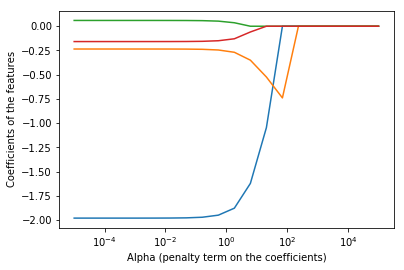

In [53]:
coefs = []
alphas = 10 ** np.linspace(-5, 5, 20)
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000, tol=1e-5,random_state=100)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

plt.plot(alphas, coefs)
plt.xscale("log")
plt.xlabel("Alpha (penalty term on the coefficients)")
plt.ylabel("Coefficients of the features")